In [298]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [3]:
# path configuration
LABELS_PATH = '../data/train_val_annotation/train_val_videodatainfo.json'
DATA_PATH = '../data/train_val_features/'

In [30]:
import json
from pickle import dump, load

In [5]:
# JSON file
f = open (LABELS_PATH, "r")
  # Reading from file
data = json.loads(f.read())

In [96]:
data['videos'][0]

{'category': 9,
 'url': 'https://www.youtube.com/watch?v=9lZi22qLlEo',
 'video_id': 'video0',
 'start time': 137.72,
 'end time': 149.44,
 'split': 'train',
 'id': 0}

In [7]:
## randomly select sentence
#label_df = pd.DataFrame(data['sentences'])
#label_final_df = label_df.groupby('video_id')['sen_id'].unique().apply(lambda x: x[np.random.randint(0,20)]).to_frame().reset_index()
#label_final_df['video_id'].nunique()
#label_final_df = label_final_df.join(label_df[['sen_id', 'caption']].set_index('sen_id'), on='sen_id')
#label_final_df.to_csv('../data/label_final.csv', index=False)

## DataSet

In [8]:
label_final_df = pd.read_csv('../data/label_final.csv')

### 1. Create embedding matrix from google news word2vec

In [9]:
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [35]:
# embedding
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))
glove_emb = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [11]:
all_sent = label_final_df['caption'].tolist()#.astype('unicode')

In [26]:
wc = Counter()
try:
    for doc in nlp.pipe(all_sent):
        for word in doc:
            #print(word)
            wc[str(word)] += 1
except Exception as e:
    print(e)
    print(doc,'\nword:', word)

In [51]:
# create embedding matrix
# initialization
EMBEDDING_SIZE = 300
embedding = np.zeros((len(wc)+4, 300)) # +4 for start, end, unk, padding
word2idx = {}
idx2word = {}

word2idx['<PAD>'] = 0
idx2word[0] = '<PAD>'
embedding[0] = np.random.rand(300)*2 - 1

word2idx['<START>'] = 1
idx2word[1] = '<START>'
embedding[1] = np.random.rand(300)*2 - 1

word2idx['<END>'] = 2
idx2word[2] = '<END>'
embedding[2] = np.random.rand(300)*2 - 1

word2idx['<UNK>'] = 3
idx2word[3] = '<UNK>'
embedding[3] = np.random.rand(300)*2 - 1

count = 0
for word, _ in wc.most_common():
    wid = len(word2idx)
    word2idx[word] = wid
    idx2word[wid] = word
    if word in glove_emb:
        embedding[wid] = glove_emb.get_vector(word)
    else:
        embedding[wid] = np.random.rand(300)*2 - 1 # random initialisation (-1, 1)
        count += 1

In [53]:
print(f'{count} words are not in google news werd2vec')

401 words are not in google news werd2vec


In [835]:
np.save('../model/embedding.npy', embedding)

In [988]:
import pickle
with open("../model/word2idx.pkl","wb") as f:
    pickle.dump(word2idx, f)


In [989]:
with open("../model/idx2word.pkl","wb") as f:
    pickle.dump(idx2word, f)

### 2.Dataset Class for pytorch

In [279]:
class MSRVTT(Dataset):
    def __init__(self, df, word2idx, DATA_PATH):
        super(MSRVTT, self).__init__()
        self.df = df
        self.path = DATA_PATH
        self.word2idx = word2idx
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid = row['video_id']
        filename = self.path + f'{vid}-feature.pt5'
        x = torch.load(filename)
        sentence_emb = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in row['caption'].split(' ')]
        y = torch.zeros(len(sentence_emb)+2)
        y[0], y[-1] = self.word2idx['<START>'], self.word2idx['<END>']
        y[1:-1] = torch.tensor(sentence_emb)
        #true_sentence = row['caption']
        return x, y.long()#, true_sentence

In [280]:
ds = MSRVTT(label_final_df, word2idx, DATA_PATH)

In [282]:
ds_iter = iter(ds)

In [285]:
x.size(0)

30

In [286]:
frames_size = []
sents_length = []
for x, y in ds_iter:
    frames_size.append(x.size(0))
    sents_length.append(len(y))

In [291]:
import matplotlib.pyplot as plt

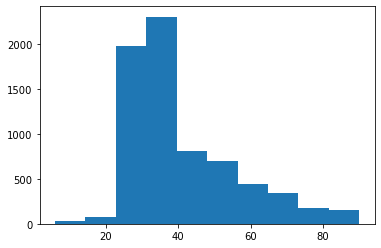

In [293]:
# frames length distribution
plt.hist(frames_size)
plt.show()

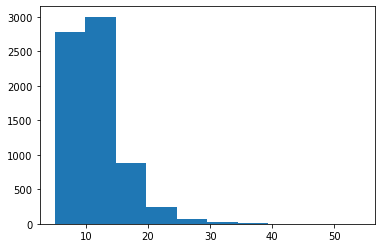

In [295]:
# sentence length distribution
plt.hist(sents_length)
plt.show()

### 3.Dataloaders

In [428]:
def collate_fn(batch):
    """
    padding  text or video
    """
    x_batch = []
    y_batch = []
    for x, y in batch:
        x_batch.append(x)
        y_batch.append(y)
    lengths = list(map(lambda x: x.size(0), x_batch))
    x_batch = torch.nn.utils.rnn.pad_sequence(x_batch,  batch_first=True)
    x_batch = torch.nn.utils.rnn.pack_padded_sequence(x_batch, lengths, batch_first=True, enforce_sorted=False)
    y_batch = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True)
    return x_batch, y_batch#, lengths  # PackedSequence, padded tensor

#torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)

In [429]:
# split train/test
train_proportion = 0.93
train_size = int(train_proportion * len(ds))
validation_size = len(ds) - train_size
print(train_size, validation_size)

6519 491


In [733]:
train_ds, validation_ds = random_split(ds, [train_size, validation_size])
# dataloaders
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(validation_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [734]:
x, y = next(iter(train_dl))

In [449]:
y

tensor([[   1, 3353,  229,   63,    4, 3354, 1113,  148,  722,    4, 1025,    9,
            4,  152,   77,  791,  657,    2],
        [   1,    4,   19,  203,    4,  989,  109, 1551,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   1,   14,   70,   80,   10,  252,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   1, 2623,   13,  161,    4, 4370,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   1,    4, 5483,    7,    6,   85,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   1,   76, 2635,   96,    5,   21,  831,   11,  223,   10,  104, 2635,
           96,    2,    0,    0,    0,    0],
        [   1,   18,   10,  501,  130,  793,   87,    2,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   1,    4,    8,    5,   17,   16,    6, 4546,  777, 4547,    9,    6,
         4548,  129,    2,    

# Model

### Sequence to Sequence Model (Encoder-Decoder)

While image description handles a variable length output sequence of words, video description also has to handle a variable length input sequence of frames. Related approaches to video description have resolved variable length input by holistic video representations [29, 28, 11], pooling over frames [39], or sub-sampling on a fixed number of input frames [43]. In contrast, in this work we propose a sequence to sequence

In [990]:

class Encoder(nn.Module):
    '''
    Take sequence of video's resnet50 features as input
    
    note: batch_first=True does not apply to hidden or cell states
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
                
    def forward(self, x):
        '''
        x: PackedSequence
        '''
        outputs, (hidden, cell_state) = self.rnn(x) 
        return hidden
    
class Decoder(nn.Module):
    '''
    Decode Hidden State from Encoder to sentence (sequence of texts)
    
    note: batch_first=True does not apply to hidden or cell states
    '''
    def __init__(self, weights, emb_dim, hidden_dim, out_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.out_dim = out_dim
        
        # layers
        self.emb = nn.Embedding.from_pretrained(torch.tensor(weights), padding_idx=0, freeze=False)
        self.rnn = nn.GRU(emb_dim + hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc_out = nn.Linear(emb_dim + hidden_dim * 2, out_dim)
                
    def forward(self, word_input, encoded_context, hidden):
        '''
        word_input: (batch_size)
        encoded_context: (1, batch_size, hidden_dim)
        hidden: (1, batch_size, hidden_dim)
        '''
        # 1 word at a time
    
        word_input = self.emb(word_input) # dim (batch, emb_dim) 
        emb_input = torch.cat([word_input, encoded_context.squeeze(0)], dim=1)
        output, hidden = self.rnn(emb_input.unsqueeze(1).float(), hidden)
        prediction = self.fc_out(torch.cat([word_input, encoded_context.squeeze(0), hidden.squeeze(0)], dim=1).float())
        return prediction, hidden 
    

In [991]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, x, y, teacher_forcing_ratio=0.8):
        '''
        x: PackedSequence
        y: (batch_size, sentence_len(padded))
        hidden: (1, batch_size, hidden_dim)
        '''
        batch_size = y.size(0)
        sentence_len = y.size(1)
        vocab_size = self.decoder.out_dim
        
        ##############
        # Initialize #
        ##############
        # tensor for final outputs
        outputs = torch.zeros(batch_size, sentence_len, vocab_size).to(self.device)
        # last hidden state of the encoder is the context
        encoded_context = self.encoder(x) # (1, batch_size, hidden_dim)
        # first hidden state 
        hidden = encoded_context # (1, batch_size, hidden_dim)
        # first input '<START>'
        word_input = y[:, 0] # (batch_size)
        for t in range(1, sentence_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(word_input, encoded_context, hidden)
            
            #place predictions in a tensor holding predictions for each token
            outputs[:, t, :] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.rand() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) # dim: (batch_size)
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            word_input = y[:, t] if teacher_force else top1

        return outputs
    

# Training 

Set up the model

In [992]:
N_VOCAB = len(word2idx)
EMB_DIM = 300
INPUT_DIM = 2048 # resnet50 fc dim
HIDDEN_DIM = 800

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(INPUT_DIM, HIDDEN_DIM)
decoder = Decoder(embedding, EMB_DIM, HIDDEN_DIM, N_VOCAB)
model = Seq2Seq(encoder, decoder, device)

weight initialization with N(0, 0.01)

In [993]:
for name, param in model.named_parameters():
    if name != 'decoder.emb.weight':
        print(name, param.shape)
        nn.init.normal_(param.data, mean=0, std=0.1)

encoder.rnn.weight_ih_l0 torch.Size([3200, 2048])
encoder.rnn.weight_hh_l0 torch.Size([3200, 800])
encoder.rnn.bias_ih_l0 torch.Size([3200])
encoder.rnn.bias_hh_l0 torch.Size([3200])
decoder.rnn.weight_ih_l0 torch.Size([2400, 1100])
decoder.rnn.weight_hh_l0 torch.Size([2400, 800])
decoder.rnn.bias_ih_l0 torch.Size([2400])
decoder.rnn.bias_hh_l0 torch.Size([2400])
decoder.fc_out.weight torch.Size([6157, 1900])
decoder.fc_out.bias torch.Size([6157])


In [994]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss(ignore_index=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=0.001, threshold_mode='rel', min_lr=0)

In [995]:
def train_one_epoch(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    
    for i, (x, y) in enumerate(tqdm(dataloader)):
        
        out = model(x, y)
        out = out.view(-1, 6157)
        y = y.view(-1)
        loss = lossFun(out, y)
        
        total_loss += loss.item()
        if i % 50 == 0:
            print(f'Batch loss: {loss.item()}')
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
    
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss



def evaluate(model, dataloader, lossFun):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for x, y in tqdm(dataloader):

            out = model(x, y)
            out = out.view(-1, 6157)
            y = y.view(-1)
            loss = lossFun(out, y)

            total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [996]:
# train 3 more epochs
EPOCHS = 5
best = 100000

for epoch in range(EPOCHS):
    print('Epoch: ', epoch)
    
    train_loss = train_one_epoch(model, train_dl, optimizer, loss_func)
    print('Train Loss: ', train_loss)
    
    valid_loss = evaluate(model, valid_dl, loss_func)
    print('Valid Loss: ', valid_loss)
    
    if valid_loss < best:
        best = valid_loss
        torch.save(model.state_dict(),  '../model/seq2seq_v2.pt')
    scheduler.step(valid_loss)

  0%|          | 0/815 [00:00<?, ?it/s]

Epoch:  0
Batch loss: 10.895195960998535


  6%|▌         | 50/815 [01:45<28:55,  2.27s/it]

Batch loss: 5.972578048706055


 12%|█▏        | 100/815 [03:33<23:55,  2.01s/it]

Batch loss: 6.184594631195068


 18%|█▊        | 150/815 [05:24<25:24,  2.29s/it]

Batch loss: 6.3312602043151855


 25%|██▍       | 200/815 [07:04<20:01,  1.95s/it]

Batch loss: 6.197211265563965


 31%|███       | 250/815 [08:50<20:08,  2.14s/it]

Batch loss: 6.206087112426758


 37%|███▋      | 300/815 [10:32<15:28,  1.80s/it]

Batch loss: 5.096564292907715


 43%|████▎     | 350/815 [12:13<15:21,  1.98s/it]

Batch loss: 4.51657772064209


 49%|████▉     | 400/815 [14:03<15:49,  2.29s/it]

Batch loss: 5.678490161895752


 55%|█████▌    | 450/815 [15:48<13:48,  2.27s/it]

Batch loss: 5.319180965423584


 61%|██████▏   | 500/815 [17:32<12:01,  2.29s/it]

Batch loss: 5.2479681968688965


 67%|██████▋   | 550/815 [19:18<09:15,  2.09s/it]

Batch loss: 4.951292991638184


 74%|███████▎  | 600/815 [21:04<07:08,  2.00s/it]

Batch loss: 5.521001815795898


 80%|███████▉  | 650/815 [22:48<05:46,  2.10s/it]

Batch loss: 6.48126745223999


 86%|████████▌ | 700/815 [24:35<03:52,  2.02s/it]

Batch loss: 5.433162212371826


 92%|█████████▏| 750/815 [26:23<02:19,  2.14s/it]

Batch loss: 4.879652500152588


 98%|█████████▊| 800/815 [28:08<00:30,  2.05s/it]

Batch loss: 5.2979021072387695


  0%|          | 1/246 [00:00<00:35,  6.94it/s]

Train Loss:  5.86527185206033


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.361417527121257
Epoch:  1
Batch loss: 4.442993640899658


  6%|▌         | 50/815 [01:47<28:40,  2.25s/it]

Batch loss: 4.22155237197876


 12%|█▏        | 100/815 [03:38<24:10,  2.03s/it]

Batch loss: 4.298394680023193


 18%|█▊        | 150/815 [05:23<22:53,  2.07s/it]

Batch loss: 5.181671619415283


 25%|██▍       | 200/815 [07:12<22:05,  2.16s/it]

Batch loss: 3.7468717098236084


 31%|███       | 250/815 [08:56<20:05,  2.13s/it]

Batch loss: 4.40576696395874


 37%|███▋      | 300/815 [10:49<19:54,  2.32s/it]

Batch loss: 4.4800543785095215


 43%|████▎     | 350/815 [12:43<18:19,  2.36s/it]

Batch loss: 5.058035850524902


 49%|████▉     | 400/815 [14:34<15:49,  2.29s/it]

Batch loss: 4.907619476318359


 55%|█████▌    | 450/815 [16:34<15:22,  2.53s/it]

Batch loss: 4.57636022567749


 61%|██████▏   | 500/815 [18:37<13:09,  2.51s/it]

Batch loss: 5.070274353027344


 67%|██████▋   | 550/815 [20:38<10:25,  2.36s/it]

Batch loss: 5.494345664978027


 74%|███████▎  | 600/815 [22:40<08:26,  2.36s/it]

Batch loss: 5.036488056182861


 80%|███████▉  | 650/815 [24:48<06:18,  2.30s/it]

Batch loss: 4.914917945861816


 86%|████████▌ | 700/815 [26:58<04:57,  2.59s/it]

Batch loss: 5.657924175262451


 92%|█████████▏| 750/815 [29:07<02:57,  2.73s/it]

Batch loss: 4.824808120727539


 98%|█████████▊| 800/815 [31:11<00:41,  2.78s/it]

Batch loss: 5.306610584259033


  0%|          | 1/246 [00:00<00:32,  7.45it/s]

Train Loss:  4.948814445039246


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.302370870985636
Epoch:  2
Batch loss: 4.452268600463867


  6%|▌         | 50/815 [02:20<35:14,  2.76s/it]

Batch loss: 4.3283491134643555


 12%|█▏        | 100/815 [04:28<30:30,  2.56s/it]

Batch loss: 4.705445766448975


 18%|█▊        | 150/815 [06:37<28:04,  2.53s/it]

Batch loss: 3.8910470008850098


 25%|██▍       | 200/815 [08:49<23:05,  2.25s/it]

Batch loss: 4.999866962432861


 31%|███       | 250/815 [11:06<25:49,  2.74s/it]

Batch loss: 4.451109409332275


 37%|███▋      | 300/815 [13:29<25:07,  2.93s/it]

Batch loss: 4.755239486694336


 43%|████▎     | 350/815 [15:55<22:51,  2.95s/it]

Batch loss: 4.482426643371582


 49%|████▉     | 400/815 [18:24<20:34,  2.97s/it]

Batch loss: 4.388445854187012


 55%|█████▌    | 450/815 [20:48<17:46,  2.92s/it]

Batch loss: 4.370365619659424


 61%|██████▏   | 500/815 [23:12<16:06,  3.07s/it]

Batch loss: 5.450248718261719


 67%|██████▋   | 550/815 [25:37<14:32,  3.29s/it]

Batch loss: 4.972387790679932


 74%|███████▎  | 600/815 [28:09<10:36,  2.96s/it]

Batch loss: 4.775010585784912


 80%|███████▉  | 650/815 [30:36<08:35,  3.13s/it]

Batch loss: 4.358238220214844


 86%|████████▌ | 700/815 [33:02<05:29,  2.87s/it]

Batch loss: 4.663406848907471


 92%|█████████▏| 750/815 [35:42<03:27,  3.19s/it]

Batch loss: 4.661268711090088


 98%|█████████▊| 800/815 [38:14<00:45,  3.03s/it]

Batch loss: 5.058087348937988


  0%|          | 1/246 [00:00<00:33,  7.26it/s]

Train Loss:  4.5680542185262665


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.298550243300151
Epoch:  3
Batch loss: 4.099019527435303


  6%|▌         | 50/815 [02:37<40:20,  3.16s/it]

Batch loss: 3.741877794265747


 12%|█▏        | 100/815 [05:19<42:02,  3.53s/it]

Batch loss: 4.618208408355713


 18%|█▊        | 150/815 [08:04<36:12,  3.27s/it]

Batch loss: 4.704126834869385


 25%|██▍       | 200/815 [11:00<34:14,  3.34s/it]

Batch loss: 4.308989524841309


 31%|███       | 250/815 [13:50<37:10,  3.95s/it]

Batch loss: 4.445973873138428


 37%|███▋      | 300/815 [16:39<28:48,  3.36s/it]

Batch loss: 3.8028063774108887


 43%|████▎     | 350/815 [19:33<24:43,  3.19s/it]

Batch loss: 3.313645839691162


 49%|████▉     | 400/815 [22:18<21:49,  3.16s/it]

Batch loss: 3.9192097187042236


 55%|█████▌    | 450/815 [25:04<19:14,  3.16s/it]

Batch loss: 4.050736427307129


 61%|██████▏   | 500/815 [27:48<17:48,  3.39s/it]

Batch loss: 4.386102676391602


 67%|██████▋   | 550/815 [30:44<16:23,  3.71s/it]

Batch loss: 3.4617974758148193


 74%|███████▎  | 600/815 [33:35<12:13,  3.41s/it]

Batch loss: 4.043606758117676


 80%|███████▉  | 650/815 [36:25<09:21,  3.40s/it]

Batch loss: 4.190135955810547


 86%|████████▌ | 700/815 [39:13<07:00,  3.66s/it]

Batch loss: 4.3465423583984375


 92%|█████████▏| 750/815 [42:01<03:29,  3.22s/it]

Batch loss: 3.7442753314971924


 98%|█████████▊| 800/815 [44:49<00:51,  3.43s/it]

Batch loss: 3.9121341705322266


  0%|          | 1/246 [00:00<00:34,  7.18it/s]

Train Loss:  4.1693411443862445


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.400744863641941
Epoch:  4
Batch loss: 3.3257477283477783


  6%|▌         | 50/815 [02:47<43:47,  3.43s/it]

Batch loss: 3.4063024520874023


 12%|█▏        | 100/815 [05:42<45:48,  3.84s/it]

Batch loss: 3.143744468688965


 18%|█▊        | 150/815 [08:39<39:50,  3.60s/it]

Batch loss: 3.3061907291412354


 25%|██▍       | 200/815 [11:34<38:55,  3.80s/it]

Batch loss: 3.6147968769073486


 31%|███       | 250/815 [14:41<35:46,  3.80s/it]

Batch loss: 3.790419101715088


 37%|███▋      | 300/815 [17:48<31:27,  3.66s/it]

Batch loss: 3.5831897258758545


 43%|████▎     | 350/815 [20:48<26:34,  3.43s/it]

Batch loss: 2.985292911529541


 49%|████▉     | 400/815 [23:36<23:46,  3.44s/it]

Batch loss: 4.0829925537109375


 55%|█████▌    | 450/815 [26:48<23:54,  3.93s/it]

Batch loss: 4.112549781799316


 61%|██████▏   | 500/815 [30:10<21:14,  4.04s/it]

Batch loss: 3.005566358566284


 67%|██████▋   | 550/815 [33:23<17:16,  3.91s/it]

Batch loss: 3.5043983459472656


 74%|███████▎  | 600/815 [36:43<15:38,  4.37s/it]

Batch loss: 3.323516607284546


 80%|███████▉  | 650/815 [40:09<11:01,  4.01s/it]

Batch loss: 4.465643405914307


 86%|████████▌ | 700/815 [43:25<07:12,  3.76s/it]

Batch loss: 3.414965867996216


 92%|█████████▏| 750/815 [46:39<04:22,  4.03s/it]

Batch loss: 3.526705741882324


 98%|█████████▊| 800/815 [49:52<00:56,  3.78s/it]

Batch loss: 3.583662748336792


  0%|          | 1/246 [00:00<00:35,  6.98it/s]

Train Loss:  3.785942546282809


100%|██████████| 246/246 [00:38<00:00,  6.37it/s]

Valid Loss:  5.534378040127638


In [997]:
# train 3 more epochs
EPOCHS = 10

for epoch in range(EPOCHS):
    print('Epoch: ', epoch)
    
    train_loss = train_one_epoch(model, train_dl, optimizer, loss_func)
    print('Train Loss: ', train_loss)
    
    valid_loss = evaluate(model, valid_dl, loss_func)
    print('Valid Loss: ', valid_loss)
    
    if valid_loss < best:
        best = valid_loss
        torch.save(model.state_dict(),  '../model/seq2seq_v2.pt')
    scheduler.step(valid_loss)

  0%|          | 0/815 [00:00<?, ?it/s]

Epoch:  0
Batch loss: 3.288926124572754


  6%|▌         | 50/815 [03:16<54:12,  4.25s/it]

Batch loss: 3.414789915084839


 12%|█▏        | 100/815 [06:30<44:12,  3.71s/it]

Batch loss: 3.8100411891937256


 18%|█▊        | 150/815 [09:36<40:58,  3.70s/it]

Batch loss: 3.1686458587646484


 25%|██▍       | 200/815 [12:46<43:41,  4.26s/it]

Batch loss: 3.845310926437378


 31%|███       | 250/815 [16:00<36:46,  3.91s/it]

Batch loss: 3.3212952613830566


 37%|███▋      | 300/815 [19:08<32:42,  3.81s/it]

Batch loss: 3.789381265640259


 43%|████▎     | 350/815 [22:30<33:53,  4.37s/it]

Batch loss: 3.0993900299072266


 49%|████▉     | 400/815 [25:44<24:51,  3.59s/it]

Batch loss: 3.411149024963379


 55%|█████▌    | 450/815 [29:02<24:55,  4.10s/it]

Batch loss: 3.4105095863342285


 61%|██████▏   | 500/815 [32:26<21:06,  4.02s/it]

Batch loss: 2.8929407596588135


 67%|██████▋   | 550/815 [35:53<20:29,  4.64s/it]

Batch loss: 3.216747283935547


 74%|███████▎  | 600/815 [39:27<15:32,  4.34s/it]

Batch loss: 3.544886589050293


 80%|███████▉  | 650/815 [43:03<11:51,  4.31s/it]

Batch loss: 2.9218175411224365


 86%|████████▌ | 700/815 [46:47<09:08,  4.77s/it]

Batch loss: 3.202073335647583


 92%|█████████▏| 750/815 [49:57<04:02,  3.72s/it]

Batch loss: 3.414421796798706


 98%|█████████▊| 800/815 [53:34<01:13,  4.93s/it]

Batch loss: 3.6156392097473145


  0%|          | 1/246 [00:00<00:34,  7.13it/s]

Train Loss:  3.4243136359138724


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.637188906592082
Epoch:  1
Batch loss: 2.9150452613830566


  6%|▌         | 50/815 [03:22<47:27,  3.72s/it] 

Batch loss: 2.872051239013672


 12%|█▏        | 100/815 [06:37<42:19,  3.55s/it]

Batch loss: 3.5218050479888916


 18%|█▊        | 150/815 [10:00<47:43,  4.31s/it]

Batch loss: 2.2760303020477295


 25%|██▍       | 200/815 [13:23<45:24,  4.43s/it]

Batch loss: 2.534259796142578


 31%|███       | 250/815 [16:57<40:21,  4.29s/it]

Batch loss: 3.201436758041382


 37%|███▋      | 300/815 [20:28<36:23,  4.24s/it]

Batch loss: 2.47163987159729


 43%|████▎     | 350/815 [23:54<32:35,  4.21s/it]

Batch loss: 3.678468704223633


 49%|████▉     | 400/815 [27:19<30:08,  4.36s/it]

Batch loss: 2.214231252670288


 55%|█████▌    | 450/815 [30:51<27:25,  4.51s/it]

Batch loss: 2.467954158782959


 61%|██████▏   | 500/815 [34:24<21:55,  4.17s/it]

Batch loss: 2.7676095962524414


 67%|██████▋   | 550/815 [38:00<19:47,  4.48s/it]

Batch loss: 2.725208282470703


 74%|███████▎  | 600/815 [41:28<14:03,  3.92s/it]

Batch loss: 3.2858006954193115


 80%|███████▉  | 650/815 [44:55<11:39,  4.24s/it]

Batch loss: 2.145493745803833


 86%|████████▌ | 700/815 [48:23<07:33,  3.94s/it]

Batch loss: 2.4268274307250977


 92%|█████████▏| 750/815 [51:53<04:29,  4.15s/it]

Batch loss: 2.3707268238067627


 98%|█████████▊| 800/815 [55:23<01:00,  4.00s/it]

Batch loss: 2.6273157596588135


  0%|          | 1/246 [00:00<00:33,  7.34it/s]

Train Loss:  2.790878115987485


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.594459586996373
Epoch:  2
Batch loss: 2.726550340652466


  6%|▌         | 50/815 [03:25<52:53,  4.15s/it] 

Batch loss: 2.2560372352600098


 12%|█▏        | 100/815 [06:49<45:06,  3.78s/it]

Batch loss: 2.20487380027771


 18%|█▊        | 150/815 [10:17<43:44,  3.95s/it]

Batch loss: 2.6934564113616943


 25%|██▍       | 200/815 [13:40<38:08,  3.72s/it]

Batch loss: 2.464979648590088


 31%|███       | 250/815 [17:06<40:08,  4.26s/it]

Batch loss: 2.4355387687683105


 37%|███▋      | 300/815 [20:36<34:57,  4.07s/it]

Batch loss: 3.048360586166382


 43%|████▎     | 350/815 [24:09<34:06,  4.40s/it]

Batch loss: 2.4597342014312744


 49%|████▉     | 400/815 [27:49<29:19,  4.24s/it]

Batch loss: 2.3636250495910645


 55%|█████▌    | 450/815 [31:21<24:53,  4.09s/it]

Batch loss: 2.5591318607330322


 61%|██████▏   | 500/815 [34:47<21:51,  4.16s/it]

Batch loss: 2.2733094692230225


 67%|██████▋   | 550/815 [38:20<16:37,  3.77s/it]

Batch loss: 2.9847400188446045


 74%|███████▎  | 600/815 [41:47<15:17,  4.27s/it]

Batch loss: 5.43100118637085


 80%|███████▉  | 650/815 [45:17<11:00,  4.00s/it]

Batch loss: 2.220446825027466


 86%|████████▌ | 700/815 [48:45<08:04,  4.21s/it]

Batch loss: 2.8647167682647705


 92%|█████████▏| 750/815 [52:09<04:28,  4.13s/it]

Batch loss: 2.273334264755249


 98%|█████████▊| 800/815 [55:31<01:00,  4.01s/it]

Batch loss: 2.3467557430267334


  0%|          | 1/246 [00:00<00:33,  7.40it/s]

Train Loss:  2.6437374335856525


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.583465581017781
Epoch:  3
Batch loss: 3.09397554397583


  6%|▌         | 50/815 [03:22<49:26,  3.88s/it]  

Batch loss: 3.3606300354003906


 12%|█▏        | 100/815 [06:44<45:10,  3.79s/it]

Batch loss: 2.7282838821411133


 18%|█▊        | 150/815 [10:13<45:01,  4.06s/it]

Batch loss: 2.155843496322632


 25%|██▍       | 200/815 [13:38<40:45,  3.98s/it]

Batch loss: 2.618917465209961


 31%|███       | 250/815 [17:05<38:48,  4.12s/it]

Batch loss: 2.3020286560058594


 37%|███▋      | 300/815 [20:27<32:48,  3.82s/it]

Batch loss: 2.600102663040161


 43%|████▎     | 350/815 [23:44<31:29,  4.06s/it]

Batch loss: 2.4871625900268555


 49%|████▉     | 400/815 [27:00<27:48,  4.02s/it]

Batch loss: 2.251356601715088


 55%|█████▌    | 450/815 [30:19<22:55,  3.77s/it]

Batch loss: 2.3514652252197266


 61%|██████▏   | 500/815 [33:40<20:47,  3.96s/it]

Batch loss: 2.5048694610595703


 67%|██████▋   | 550/815 [36:58<19:50,  4.49s/it]

Batch loss: 3.1336495876312256


 74%|███████▎  | 600/815 [40:18<13:47,  3.85s/it]

Batch loss: 2.9815351963043213


 80%|███████▉  | 650/815 [43:27<10:13,  3.72s/it]

Batch loss: 2.508789539337158


 86%|████████▌ | 700/815 [46:44<07:25,  3.88s/it]

Batch loss: 3.6661245822906494


 92%|█████████▏| 750/815 [49:54<04:27,  4.12s/it]

Batch loss: 2.8717665672302246


 98%|█████████▊| 800/815 [53:10<01:02,  4.17s/it]

Batch loss: 2.000945568084717


  0%|          | 1/246 [00:00<00:34,  7.20it/s]

Train Loss:  2.6076464294655923


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.654313105877822
Epoch:  4
Batch loss: 2.846193790435791


  6%|▌         | 50/815 [03:17<49:47,  3.90s/it]  

Batch loss: 2.8823015689849854


 12%|█▏        | 100/815 [06:32<46:57,  3.94s/it]

Batch loss: 2.9183576107025146


 18%|█▊        | 150/815 [09:55<43:58,  3.97s/it]

Batch loss: 2.2155611515045166


 25%|██▍       | 200/815 [13:23<46:43,  4.56s/it]

Batch loss: 2.032561779022217


 31%|███       | 250/815 [16:35<37:14,  3.96s/it]

Batch loss: 2.2459986209869385


 37%|███▋      | 300/815 [19:59<35:49,  4.17s/it]

Batch loss: 2.5476529598236084


 43%|████▎     | 350/815 [23:16<31:07,  4.02s/it]

Batch loss: 2.8492627143859863


 49%|████▉     | 400/815 [26:33<27:07,  3.92s/it]

Batch loss: 1.7897876501083374


 55%|█████▌    | 450/815 [29:47<26:08,  4.30s/it]

Batch loss: 2.019622564315796


 61%|██████▏   | 500/815 [33:03<20:13,  3.85s/it]

Batch loss: 2.761882781982422


 67%|██████▋   | 550/815 [36:18<15:58,  3.62s/it]

Batch loss: 2.8901572227478027


 74%|███████▎  | 600/815 [39:28<13:16,  3.70s/it]

Batch loss: 1.900978684425354


 80%|███████▉  | 650/815 [42:45<09:51,  3.58s/it]

Batch loss: 5.615318775177002


 86%|████████▌ | 700/815 [45:52<07:06,  3.71s/it]

Batch loss: 2.9503657817840576


 92%|█████████▏| 750/815 [48:58<03:58,  3.68s/it]

Batch loss: 3.5136430263519287


 98%|█████████▊| 800/815 [52:13<01:01,  4.10s/it]

Batch loss: 2.2723207473754883


  0%|          | 1/246 [00:00<00:33,  7.39it/s]

Train Loss:  2.535029107953873


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.690314993625734
Epoch:  5
Batch loss: 2.7379870414733887


  6%|▌         | 50/815 [03:14<48:53,  3.83s/it]

Batch loss: 2.6338717937469482


 12%|█▏        | 100/815 [06:27<44:08,  3.70s/it]

Batch loss: 1.9000340700149536


 18%|█▊        | 150/815 [09:47<44:42,  4.03s/it]

Batch loss: 2.1935083866119385


 25%|██▍       | 200/815 [13:05<41:58,  4.10s/it]

Batch loss: 2.5161638259887695


 31%|███       | 250/815 [16:23<34:01,  3.61s/it]

Batch loss: 1.8778728246688843


 37%|███▋      | 300/815 [19:42<35:35,  4.15s/it]

Batch loss: 2.527053117752075


 43%|████▎     | 350/815 [22:59<29:40,  3.83s/it]

Batch loss: 2.2019119262695312


 49%|████▉     | 400/815 [26:09<26:17,  3.80s/it]

Batch loss: 2.6438145637512207


 55%|█████▌    | 450/815 [29:21<22:36,  3.72s/it]

Batch loss: 2.1781039237976074


 61%|██████▏   | 500/815 [32:35<20:55,  3.98s/it]

Batch loss: 2.0165061950683594


 67%|██████▋   | 550/815 [35:51<15:49,  3.58s/it]

Batch loss: 2.249624490737915


 74%|███████▎  | 600/815 [39:03<13:05,  3.66s/it]

Batch loss: 1.8848438262939453


 80%|███████▉  | 650/815 [42:10<11:04,  4.03s/it]

Batch loss: 3.1240451335906982


 86%|████████▌ | 700/815 [45:26<08:04,  4.22s/it]

Batch loss: 2.5542349815368652


 92%|█████████▏| 750/815 [48:39<04:41,  4.33s/it]

Batch loss: 3.442044496536255


 98%|█████████▊| 800/815 [51:52<01:04,  4.30s/it]

Batch loss: 2.705294370651245


  0%|          | 1/246 [00:00<00:35,  6.96it/s]

Train Loss:  2.4207137021550373


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.659771249546268
Epoch:  6
Batch loss: 1.8670252561569214


  6%|▌         | 50/815 [03:11<48:38,  3.81s/it]

Batch loss: 2.413853406906128


 12%|█▏        | 100/815 [06:28<47:51,  4.02s/it]

Batch loss: 2.536505937576294


 18%|█▊        | 150/815 [09:42<42:19,  3.82s/it]

Batch loss: 2.397796392440796


 25%|██▍       | 200/815 [13:00<40:09,  3.92s/it]

Batch loss: 2.6697158813476562


 31%|███       | 250/815 [16:17<35:04,  3.72s/it]

Batch loss: 2.896747350692749


 37%|███▋      | 300/815 [19:29<33:56,  3.95s/it]

Batch loss: 2.2392423152923584


 43%|████▎     | 350/815 [22:50<30:17,  3.91s/it]

Batch loss: 2.587428092956543


 49%|████▉     | 400/815 [26:04<23:56,  3.46s/it]

Batch loss: 1.9952303171157837


 55%|█████▌    | 450/815 [29:39<28:00,  4.60s/it]

Batch loss: 2.0487680435180664


 61%|██████▏   | 500/815 [33:05<25:33,  4.87s/it]

Batch loss: 2.555377721786499


 67%|██████▋   | 550/815 [36:27<16:52,  3.82s/it]

Batch loss: 3.2316091060638428


 74%|███████▎  | 600/815 [39:46<14:03,  3.92s/it]

Batch loss: 2.193516969680786


 80%|███████▉  | 650/815 [43:23<12:37,  4.59s/it]

Batch loss: 2.4419987201690674


 86%|████████▌ | 700/815 [47:03<08:52,  4.63s/it]

Batch loss: 2.263507843017578


 92%|█████████▏| 750/815 [50:29<04:39,  4.30s/it]

Batch loss: 3.022754669189453


 98%|█████████▊| 800/815 [54:08<01:10,  4.69s/it]

Batch loss: 2.282520055770874


  0%|          | 0/246 [00:00<?, ?it/s]

Train Loss:  2.4105135265303534


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.673222916882213
Epoch:  7
Batch loss: 2.1299219131469727


  6%|▌         | 50/815 [03:32<55:56,  4.39s/it]  

Batch loss: 4.2874956130981445


 12%|█▏        | 100/815 [06:54<51:34,  4.33s/it]

Batch loss: 2.1150753498077393


 18%|█▊        | 150/815 [10:17<42:37,  3.85s/it]

Batch loss: 2.00691819190979


 25%|██▍       | 200/815 [13:37<50:56,  4.97s/it]

Batch loss: 2.400045394897461


 31%|███       | 250/815 [16:55<36:18,  3.86s/it]

Batch loss: 2.698362112045288


 37%|███▋      | 300/815 [20:18<39:14,  4.57s/it]

Batch loss: 3.3843696117401123


 43%|████▎     | 350/815 [23:45<30:28,  3.93s/it]

Batch loss: 2.9177303314208984


 49%|████▉     | 400/815 [27:06<29:44,  4.30s/it]

Batch loss: 3.4649641513824463


 55%|█████▌    | 450/815 [30:49<29:04,  4.78s/it]

Batch loss: 2.2644479274749756


 61%|██████▏   | 500/815 [34:21<22:08,  4.22s/it]

Batch loss: 2.462034225463867


 67%|██████▋   | 550/815 [37:56<20:42,  4.69s/it]

Batch loss: 1.9889819622039795


 74%|███████▎  | 600/815 [41:19<14:18,  3.99s/it]

Batch loss: 2.3550732135772705


 80%|███████▉  | 650/815 [44:38<11:26,  4.16s/it]

Batch loss: 2.5111501216888428


 86%|████████▌ | 700/815 [48:01<07:45,  4.05s/it]

Batch loss: 2.400027275085449


 92%|█████████▏| 750/815 [51:18<04:34,  4.23s/it]

Batch loss: 3.5578994750976562


 98%|█████████▊| 800/815 [54:48<01:00,  4.04s/it]

Batch loss: 1.7631117105484009


  0%|          | 1/246 [00:00<00:34,  7.00it/s]

Train Loss:  2.452308704077832


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.693195154027241
Epoch:  8
Batch loss: 2.128972291946411


  6%|▌         | 50/815 [03:26<49:21,  3.87s/it]  

Batch loss: 1.853293538093567


 12%|█▏        | 100/815 [07:13<50:17,  4.22s/it] 

Batch loss: 2.155749559402466


 18%|█▊        | 150/815 [10:46<49:40,  4.48s/it]

Batch loss: 3.2683980464935303


 25%|██▍       | 200/815 [14:20<46:46,  4.56s/it]

Batch loss: 3.538771629333496


 31%|███       | 250/815 [17:59<44:43,  4.75s/it]

Batch loss: 2.977524757385254


 37%|███▋      | 300/815 [21:33<35:01,  4.08s/it]

Batch loss: 2.197227716445923


 43%|████▎     | 350/815 [24:50<30:10,  3.89s/it]

Batch loss: 1.728014349937439


 49%|████▉     | 400/815 [28:15<32:41,  4.73s/it]

Batch loss: 2.6556527614593506


 55%|█████▌    | 450/815 [31:39<25:27,  4.18s/it]

Batch loss: 1.999891757965088


 61%|██████▏   | 500/815 [35:07<22:41,  4.32s/it]

Batch loss: 2.3579108715057373


 67%|██████▋   | 550/815 [38:14<16:39,  3.77s/it]

Batch loss: 2.555555582046509


 74%|███████▎  | 600/815 [41:31<14:34,  4.07s/it]

Batch loss: 1.9512258768081665


 80%|███████▉  | 650/815 [44:50<10:33,  3.84s/it]

Batch loss: 2.8996174335479736


 86%|████████▌ | 700/815 [48:00<07:43,  4.03s/it]

Batch loss: 2.277621269226074


 92%|█████████▏| 750/815 [51:10<03:56,  3.64s/it]

Batch loss: 2.479888439178467


 98%|█████████▊| 800/815 [54:33<00:59,  4.00s/it]

Batch loss: 1.886354684829712


  0%|          | 1/246 [00:00<00:34,  7.12it/s]

Train Loss:  2.4135723013088017


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.675348449528702
Epoch:  9
Batch loss: 2.027581214904785


  6%|▌         | 50/815 [03:16<51:33,  4.04s/it] 

Batch loss: 2.8707263469696045


 12%|█▏        | 100/815 [06:33<51:14,  4.30s/it]

Batch loss: 2.524771213531494


 18%|█▊        | 150/815 [09:44<41:48,  3.77s/it]

Batch loss: 2.2601823806762695


 25%|██▍       | 200/815 [12:58<37:36,  3.67s/it]

Batch loss: 2.4413468837738037


 31%|███       | 250/815 [16:07<33:22,  3.54s/it]

Batch loss: 2.083097457885742


 37%|███▋      | 300/815 [19:19<32:37,  3.80s/it]

Batch loss: 2.5412755012512207


 43%|████▎     | 350/815 [22:36<27:49,  3.59s/it]

Batch loss: 2.044264316558838


 49%|████▉     | 400/815 [25:44<24:51,  3.59s/it]

Batch loss: 3.3726675510406494


 55%|█████▌    | 450/815 [28:55<25:33,  4.20s/it]

Batch loss: 2.3950836658477783


 61%|██████▏   | 500/815 [32:06<20:46,  3.96s/it]

Batch loss: 1.9390770196914673


 67%|██████▋   | 550/815 [35:20<15:52,  3.60s/it]

Batch loss: 2.707257032394409


 74%|███████▎  | 600/815 [38:39<13:40,  3.82s/it]

Batch loss: 2.934483051300049


 80%|███████▉  | 650/815 [41:56<10:06,  3.68s/it]

Batch loss: 2.4642691612243652


 86%|████████▌ | 700/815 [45:09<06:52,  3.59s/it]

Batch loss: 3.2341177463531494


 92%|█████████▏| 750/815 [48:18<04:07,  3.81s/it]

Batch loss: 2.6301233768463135


 98%|█████████▊| 800/815 [51:34<01:01,  4.10s/it]

Batch loss: 2.6967403888702393


  0%|          | 1/246 [00:00<00:35,  6.92it/s]

Train Loss:  2.3787213072455002


100%|██████████| 246/246 [00:38<00:00,  6.31it/s]

Valid Loss:  5.680067991822716


In [1058]:
model.eval()
with torch.no_grad():
    context = model.encoder(test_x.unsqueeze(0))
context

tensor([[[ 8.3415e-07,  1.8757e-08, -1.0000e+00, -7.6159e-01,  2.7992e-12,
          -3.5686e-05,  8.0224e-15, -1.5713e-10, -1.4366e-13,  3.3050e-13,
           2.0661e-21,  1.0000e+00, -1.2542e-10, -4.9077e-11, -9.7051e-05,
           1.3208e-20,  7.0467e-07,  1.1476e-12, -1.8057e-11,  8.1142e-15,
          -3.8975e-02, -1.4302e-16, -1.0386e-09, -2.6230e-12,  7.6159e-01,
          -2.6330e-23, -1.2532e-02, -5.2528e-04, -1.2949e-07,  2.4892e-08,
           6.0026e-07, -1.1196e-10,  1.5296e-10, -5.0617e-09,  2.4082e-09,
          -3.3455e-08, -1.0477e-16,  4.9381e-16, -9.8111e-22,  1.8580e-14,
          -4.9357e-11,  1.0770e-11,  4.9214e-10,  9.3780e-16, -6.4904e-04,
           1.0489e-06,  5.5468e-14,  1.2570e-05, -5.2065e-02, -1.0022e-04,
          -1.2523e-10, -3.3691e-08,  1.9675e-05, -1.4091e-15,  1.4231e-01,
           1.4667e-12,  5.1739e-10, -5.8571e-08, -3.2723e-04,  1.1033e-10,
          -3.1379e-28, -2.8651e-10, -1.4404e-19, -9.0455e-08, -7.8566e-11,
           1.3765e-10,  4

# Model Diagnosis

In [1079]:
def gen_seq(model, x, start_token, seq_length):
    with torch.no_grad():
        word_input = torch.tensor(word2idx[start_token]).unsqueeze(0)
        context = model.encoder(x.unsqueeze(0))
        hidden = context
        outputs = [start_token]
        ## generate a sequence!
        for i in range(seq_length):
            output, hidden = model.decoder(word_input, context, hidden)
            word = output.argmax(1)
            outputs.append(idx2word[word.item()])
            word_input = word
        return outputs

In [1069]:
iterator = iter(train_ds)

In [1076]:
test_x, test_y = next(iterator)
test_x.shape

torch.Size([50, 2048])

tensor([   1,    4, 1082,   25, 5597,  104,   25,  219,    5, 2308,  305,   12,
           4,  389,    2])

In [1082]:
[idx2word[word.item()] for word in test_y]

['<START>',
 'a',
 'teenage',
 'girl',
 'teases',
 'another',
 'girl',
 'who',
 'is',
 'blindfolded',
 'next',
 'to',
 'a',
 'river',
 '<END>']

In [1078]:
gen_seq(model, test_x,  '<START>', 15)

tensor([[ 1.4117e-07,  8.7523e-09, -1.0000e+00, -7.6159e-01,  3.1522e-14,
         -3.8256e-06,  1.7946e-15, -1.5878e-11, -6.9432e-16,  2.3584e-15,
          1.6964e-22,  1.0000e+00, -2.9911e-12, -1.3260e-12, -6.8926e-03,
          1.2900e-22,  3.9233e-08,  1.9082e-13, -6.0221e-12,  3.7145e-15,
         -6.2369e-03, -7.8452e-15, -9.1389e-10, -1.4576e-13,  7.6159e-01,
         -3.6218e-25, -4.9680e-03, -2.1962e-04, -1.4119e-09, -1.8743e-08,
          6.3280e-08, -1.4303e-11,  1.7118e-11, -1.7941e-09,  1.9121e-10,
         -2.3796e-08, -3.5009e-14,  7.3931e-16, -4.8089e-22,  2.3265e-13,
         -8.8118e-11,  5.9196e-12,  6.9587e-11,  5.1894e-16, -4.3336e-06,
          1.3440e-05,  2.3725e-14,  3.2155e-04, -4.9125e-01, -4.2814e-04,
         -1.0928e-10, -4.0647e-09,  1.0124e-05, -4.2381e-17,  6.6224e-02,
          1.7039e-13,  4.5293e-11, -2.1232e-09, -5.8124e-06,  2.0353e-11,
         -5.4074e-28, -4.1671e-11,  9.0823e-21, -4.6344e-07, -4.0680e-09,
          1.1559e-11,  4.7354e-08,  2.

['<START>',
 'a',
 'man',
 'is',
 'talking',
 'about',
 'a',
 'car',
 '<END>',
 '<END>',
 'his',
 'father',
 'in',
 'a',
 'home',
 '<END>']